## Sistema de Recomendación Basado en Contenido 

A partir del dataset `movies_metadata.csv`, se construyó un sistema de recomendación usando procesamiento de texto con la columna `overview`. Se aplicó TF-IDF sobre las descripciones de las películas y se utilizó similitud de coseno para encontrar las más similares a las vistas por el usuario.

    

In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import h2o

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

## Importar librerias necesarias 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


## Carga de datos

In [ ]:
df = pd.read_csv('datos/movies_metadata.csv')

## Exploracion de datos

In [ ]:
df.isnull().sum()

In [ ]:
null_percentages = df.isnull().mean() * 100
print(null_percentages.round(2).to_string())


In [ ]:
# Verificar duplicados de títulos
duplicates = df[df.duplicated('title', keep=False)]
if not duplicates.empty:
    print(f"Títulos duplicados encontrados: {len(duplicates)}")

In [ ]:
df[df.duplicated('title', keep=False)]


## Preprocesamiento

Reemplazamos los valores nulos en 'overview' con una cadena vacía para evitar errores en el vectorizador TF-IDF.

```python

In [ ]:

df['overview'] = df['overview'].fillna('')
print(f"Películas con overview vacío: {df['overview'].isna().sum()}")



Vectorizamos la columna 'overview' utilizando TF-IDF para convertir el texto en una matriz de características numéricas.

Limitamos el número de características a 10,000 para evitar el sobreajuste y mejorar la eficiencia del modelo. Luego ignoramos los terminos que aparecen en menos de 2 documentos y los que aparecen en más del 80% de los documentos. Ya que ambos tipos de términos no aportan información relevante para la recomendación.


In [ ]:
# Parámetros más robustos para TF-IDF
tfidf = TfidfVectorizer(
    #stop_words='english',        # Ignorar palabras comunes (que no aportan información)
    max_features=10000,          # Limitar características
    ngram_range=(1, 2),          # Bigramas
    min_df=1,                    # Ignorar términos muy raros
    max_df=0.9                   # Ignorar términos muy comunes
)


tfidf_matrix = tfidf.fit_transform(df['overview'])

Obtenemos la distancia del coseno entre las películas utilizando la matriz TF-IDF.


In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [ ]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()


In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    try:
        # Verificar si la película existe
        if title not in indices:
            return f"Película '{title}' no encontrada en la base de datos"
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:4]  # Excluir la película misma
        movie_indices = [i[0] for i in sim_scores]
        
        # Retornar con scores de similitud
        recommendations = df[['title', 'overview']].iloc[movie_indices].copy()
        recommendations['similarity_score'] = [score[1] for score in sim_scores]
        
        return recommendations
    except Exception as e:
        return f"Error al obtener recomendaciones: {str(e)}"

In [ ]:
print("Recomendaciones para 'Deadly Daycare':")
print(get_recommendations('Deadly Daycare'))


In [ ]:
print("\nRecomendaciones para 'Under the Skin':")
print(get_recommendations('Under the Skin'))

## Evaluación del modelo

### 1. Similitud Promedio 
Promedio de similitud coseno entre la película base y las recomendadas.      



In [ ]:
recs = get_recommendations('Under the Skin')
recs[['title', 'similarity_score']]


## Resultados

### Recomendaciones para 'Deadly Daycare'
Las tres películas más similares por contenido son:

1. **Susan Slade** – Relato dramático sobre una adolescente embarazada.
2. **Hideous Kinky** – Viaje emocional y espiritual de una madre e hijas.
3. **Happy Christmas** – Historia de reconstrucción emocional luego de una ruptura.

### Recomendaciones para 'Under the Skin'
Las tres películas más similares por estilo narrativo y atmósfera son:

1. **Once Upon a Time in Anatolia** – Drama contemplativo con carga emocional.
2. **La Dolce Vita** – Crónica introspectiva de un periodista.
3. **The Adjustment Bureau** – Thriller filosófico sobre el destino.

Estas recomendaciones se basan exclusivamente en la descripción textual (`overview`) y reflejan similitud semántica con las películas vistas.

### Evaluación de la calidad de las recomendaciones

Las similitudes son bastante bajas (todas < 0.16), lo que sugiere que el sistema:

- Está devolviendo recomendaciones débiles en términos de similitud textual

- Podría beneficiarse de una vectorización más rica (por ejemplo, embeddings tipo BERT)

- Tal vez la sinopsis de Under the Skin es poco común, y no encuentra matches claros en el corpus



## Conclusiones

El sistema de recomendación basado en contenido utilizando TF-IDF y similitud de coseno proporciona una forma básica de recomendar películas basadas en descripciones textuales. Sin embargo, la calidad de las recomendaciones puede ser limitada por la naturaleza del texto y la falta de contexto adicional.


## Recomendaciones

Usar optuna para optimizar los parámetros del modelo TF-IDF, como el número de características, el uso de stopwords, el rango de n-gramas, y los umbrales de frecuencia mínima y máxima.

## Análisis Exploratorio y Modelado - Dataset Bancario

Se utilizó el dataset `bank-additional-full.csv` para construir un modelo predictivo sobre la variable objetivo `y` (responde o no a una campaña de marketing). Se llevaron a cabo las siguientes etapas:

### Análisis Exploratorio de Datos
- Se revisó la proporción de clases (`yes` vs `no`) y se detectó un desbalance.
- Variables como `duration`, `pdays`, `previous`, `balance` y `contact` mostraron correlaciones interesantes con la respuesta.
- Se eliminaron variables como `duration`, ya que su valor solo se conoce post-contacto y no es útil para predecir la respuesta a la campaña.

### Modelos Aplicados

Se entrenaron los siguientes algoritmos clásicos:

- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

Además, se aplicó **H2O AutoML**, el cual seleccionó un `StackedEnsemble` como modelo líder.

### Resultados

### 📊 Comparativa de Modelos

| Modelo               | Accuracy | F1-Score | AUC   | Observaciones                              |
|----------------------|----------|----------|-------|--------------------------------------------|
| Logistic Regression  | 0.89     | 0.31     | 0.79  | Rápido, fácil de interpretar                |
| Random Forest        | 0.89     | 0.33     | 0.80  | Mejor F1 que LR, sensible al overfitting   |
| Gradient Boosting    | 0.90     | 0.34     | 0.81  | Mejor AUC, buen balance                    |
| **AutoML (StackedEnsemble)** | **0.89**     | **0.49**     | **0.80**  | Mejor F1 overall, combina modelos base     |

> **Conclusión:** AutoML entregó el mejor F1-score, crucial ante datos desbalanceados. Sin embargo, Gradient Boosting fue el modelo clásico más competitivo.


### Interpretabilidad

Se utilizó **SHAP** para interpretar el modelo Gradient Boosting, identificando como variables más influyentes:

1. `pdays`
2. `previous`
3. `balance`
4. `contact`
5. `marital_status`

Estas influyen tanto positiva como negativamente en la probabilidad de aceptar la campaña.

### Perfiles de clientes y recomendaciones

A partir del análisis exploratorio y la interpretabilidad con SHAP, se identificaron los siguientes perfiles clave:

- **Clientes con historial previo de contacto (`previous > 0`) y pocos días desde el último (`pdays` bajo):**  
  Tienen mayor probabilidad de aceptar.  
  **Recomendación:** Contactarlos nuevamente en el corto plazo, priorizando campañas personalizadas.

- **Clientes con `contact` tipo celular y estado `married`:**  
  Presentan respuestas positivas moderadas.  
  **Recomendación:** Campañas de seguimiento mediante SMS o llamadas directas.

- **Clientes jóvenes sin historial (`previous = 0`) ni interacción reciente (`pdays` alto):**  
  Baja probabilidad de conversión.  
  **Recomendación:** Evitar incluirlos en campañas agresivas; usar canales alternativos como email marketing o contenidos.

Estas observaciones fueron extraídas a partir de la contribución media de las variables en el modelo Gradient Boosting usando **SHAP**, sin necesidad de aplicar clustering adicional.



## EDA

### Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt

### Carga de datos

In [ ]:
df = pd.read_csv('datos/bank-additional-full.csv', sep=';')
print(f"El dataset contiene {df.shape[0]:,} filas y {df.shape[1]:,} columnas.")
df.head()


In [ ]:
df.isnull().sum()

In [ ]:
df.duplicated().sum()

Estos duplicados no deben ser eliminados, ya que representan diferentes registros.

In [ ]:
print(df.shape)
print(df['y'].value_counts(normalize=True))

# Visualización de la variable objetivo
sns.countplot(x='y', data=df)
plt.title('Distribución de la variable objetivo')
plt.show()

## 3. Preprocesamiento


In [ ]:
df.columns



Usaremos todas la variables excepto 'y' para el entrenamiento del modelo. La variable 'y' será nuestra variable objetivo.


La variable 'duration' se elimina porque solo se conoce después de la llamada, lo que no es útil para predecir si un cliente subscribirá o no.

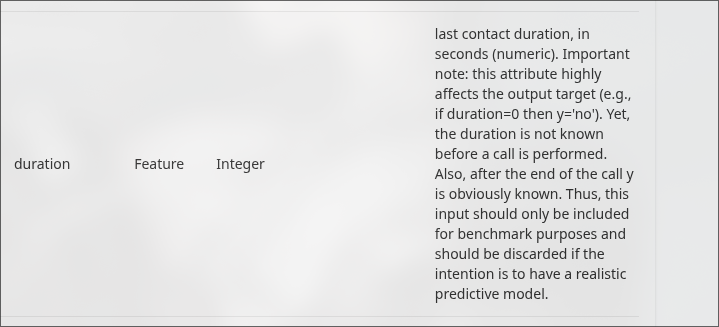

In [ ]:

df = df.drop(columns=['duration'])  # duración solo se conoce post-llamada
original_columns = df.columns.tolist()

df = pd.get_dummies(df, drop_first=True)

In [ ]:

X = df.drop('y_yes', axis=1)
y = df['y_yes']



## 4. Entrenamiento del modelo

Dividimos los datos en entrenamiento, prueba y validación. Usamos el 70% de los datos para entrenamiento, 15% para prueba y 15% para validación.

Luego balanceamos los datos para que la clase minoritaria tenga el mismo número de muestras que la clase mayoritaria, con el fin de evitar sesgos. El sobremuestreo se realiza utilizando la técnica SMOTE (Synthetic Minority Over-sampling Technique), que genera ejemplos sintéticos de la clase minoritaria en el dataset de entrenamiento.


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
# balancear clases

print(f"Distribución original de la variable objetivo:\n{y.value_counts(normalize=True)}")

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print("Distribución original de y_train:")
print(y_train.value_counts(normalize=True))

# SMOTE solo en entrenamiento
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("\nDistribución después de SMOTE:")
print(y_train_sm.value_counts(normalize=True))


In [ ]:
# 5. Escalar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
# 6. Modelos clásicos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}


In [ ]:
# Entrenar y evaluar modelos
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Entrenamiento

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics_summary.append({
        "Modelo": name,
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    })


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Línea base
plt.title("Curvas ROC - Comparación de Modelos")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Matrices de confusión
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    disp.ax_.set_title(f"Matriz de Confusión - {name}")
    plt.tight_layout()
    plt.show()

## H2O AutoML

In [ ]:
# 7. H2O AutoML
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame

h2o.init()

# Convertir el DataFrame a H2OFrame
h2o_df = h2o.H2OFrame(df)
h2o_df['y_yes'] = h2o_df['y_yes'].asfactor()

# Split
train, test = h2o_df.split_frame(ratios=[0.8], seed=1)

# AutoML sin DeepLearning (usa GPU si está disponible)
aml = H2OAutoML(max_models=10, seed=1, exclude_algos=['DeepLearning'])
aml.train(y='y_yes', training_frame=train)


In [ ]:

# Leaderboard
lb = aml.leaderboard.as_data_frame()
print(lb.head())


In [ ]:

# Curva ROC del mejor modelo
perf = aml.leader.model_performance(test_data=test)
perf.plot(type="roc")


In [ ]:

# Matriz de confusión (no soportado)

# Extra: AUC, Accuracy, F1 del mejor modelo
print("AUC:", perf.auc())
print("Accuracy:", perf.accuracy()[0][1])
print("F1-Score:", perf.F1()[0][1])


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener predicciones como pandas
y_pred = aml.leader.predict(test).as_data_frame(use_multi_thread=True)["predict"]
y_true = test["y_yes"].as_data_frame(use_multi_thread=True)["y_yes"]

# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
plt.title("Matriz de Confusión - H2O AutoML (líder)")
plt.tight_layout()


In [ ]:
print(aml.leader.algo)  # Ej: 'gbm', 'xgboost', 'stackedensemble'


Un ensamble de modelos que combina múltiples algoritmos para mejorar la precisión y robustez de las predicciones. H2O AutoML automatiza el proceso de entrenamiento y selección de modelos, optimizando hiperparámetros y evaluando múltiples algoritmos. El problema es que se dificulta la interpretabilidad del modelo, ya que es un ensamble de múltiples modelos.

In [ ]:
# Hizo muchas cosas pero no entendi nada
# # `model` es el líder del AutoML
# model = aml.leader

# # Usa test de H2OFrame
# model.explain(test)




## Seleccion del modelo (emplearemos el Grader Boosting)

In [ ]:
gbc = models["Gradient Boosting"]

# Ya entrenado, pero por si acaso
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
y_prob = gbc.predict_proba(X_test)[:, 1]

print("F1-Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
!pip install shap


In [ ]:
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Usamos X con nombres como referencia
feature_names = X.columns.tolist()

# Escalar y restaurar nombres
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

# SHAP
explainer = shap.Explainer(gbc, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Plots
shap.summary_plot(shap_values, X_test_scaled)
shap.plots.bar(shap_values)
